In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  2


In [2]:
pip install -e .

Obtaining file:///root/notebooks/0858611-2/tf-explain
  Found existing installation: tf-explain 0.2.1
    Uninstalling tf-explain-0.2.1:
      Successfully uninstalled tf-explain-0.2.1
  Running setup.py develop for tf-explain
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import tf_explain

In [4]:
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input,Dropout


def my_convolution_model(input_shape, classes):
    inputs=Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu',name='target_layer')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(classes)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape= (256,256,1)
classes    = 3
batch_size = 128
epochs     = 1

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    model_convolution = my_convolution_model(input_shape, classes)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [5]:
model_convolution.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
target_layer (Conv2D)        (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0     

In [6]:
#prepare training data
import pandas as pd
import cv2
train_csv_path = '/root/notebooks/0858611-2/tooth_xray/model/700_700/image_generate_all_rotate/train_label.csv'
train_tooth_dataframe = pd.read_csv (train_csv_path)
#tooth_dataframe = tooth_dataframe.sort_values(by=['Image_path'][-35:])
print (train_tooth_dataframe.head())

train_img_path_list = train_tooth_dataframe.Image_path
train_img_label_list = train_tooth_dataframe.label

                                          Image_path  label
0  /root/notebooks/0858611-2/tooth_xray/model/700...      2
1  /root/notebooks/0858611-2/tooth_xray/model/700...      1
2  /root/notebooks/0858611-2/tooth_xray/model/700...      2
3  /root/notebooks/0858611-2/tooth_xray/model/700...      2
4  /root/notebooks/0858611-2/tooth_xray/model/700...      1


In [7]:
def imgpath_list_to_array_list(imgpath_list,imgsize=(256,256)):
    array_list = []
    for img_path in imgpath_list:
        img = cv2.imread(img_path,0)
        img = cv2.resize(img,imgsize)
        #img = img[:,:,0]
        #img = (img-127.5)/127.5
        array_list.append(img.reshape(256,256))
    return np.array(array_list)


In [8]:
#prepare test data
import pandas as pd
test_csv_path = '/root/notebooks/0858611-2/tooth_xray/model/700_700/image_generate_all_rotate/test_label.csv'
test_tooth_dataframe = pd.read_csv (test_csv_path)
#tooth_dataframe = tooth_dataframe.sort_values(by=['Image_path'][-35:])
print (test_tooth_dataframe.head())
test_img_path_list = test_tooth_dataframe.Image_path
test_img_label_list = test_tooth_dataframe.label

test_data_array = imgpath_list_to_array_list(test_tooth_dataframe.Image_path)
test_label_array = np.array(test_tooth_dataframe.label)
test_data_array = test_data_array[..., tf.newaxis].astype('float32')
test_label_array = tf.keras.utils.to_categorical(test_label_array, num_classes=3)

                                          Image_path  label
0  /root/notebooks/0858611-2/tooth_xray/model/700...      0
1  /root/notebooks/0858611-2/tooth_xray/model/700...      0
2  /root/notebooks/0858611-2/tooth_xray/model/700...      2
3  /root/notebooks/0858611-2/tooth_xray/model/700...      1
4  /root/notebooks/0858611-2/tooth_xray/model/700...      2


In [9]:
normal_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 0]
medium_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 1]
serious_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 2]
print(len(normal_dataframe))
print(len(medium_dataframe))
print(len(serious_dataframe))

from sklearn.utils import shuffle
normal_dataframe = shuffle(normal_dataframe)
medium_dataframe = shuffle(medium_dataframe)
serious_dataframe = shuffle(serious_dataframe)

12400
8000
3600


In [10]:
min_len = min(len(normal_dataframe),len(medium_dataframe),len(serious_dataframe))
print(min_len)

3600


In [11]:
from sklearn.utils import shuffle

train_tooth_dataframe = pd.concat([normal_dataframe[:min_len],medium_dataframe[:min_len],serious_dataframe[:min_len]],axis=0)
print(len(train_tooth_dataframe))
train_tooth_dataframe = shuffle(train_tooth_dataframe)
print(train_tooth_dataframe.head())

10800
                                              Image_path  label
7123   /root/notebooks/0858611-2/tooth_xray/model/700...      2
15374  /root/notebooks/0858611-2/tooth_xray/model/700...      0
6581   /root/notebooks/0858611-2/tooth_xray/model/700...      2
19750  /root/notebooks/0858611-2/tooth_xray/model/700...      0
5847   /root/notebooks/0858611-2/tooth_xray/model/700...      2


In [12]:
#img to array and resize 
import cv2
import numpy as np
import matplotlib.pyplot as plt
imgsize = (256,256)


train_data_array = imgpath_list_to_array_list(train_tooth_dataframe.Image_path)
train_label_array = np.array(train_tooth_dataframe.label)
train_data_array = train_data_array[..., tf.newaxis].astype('float32')
train_label_array = tf.keras.utils.to_categorical(train_label_array, num_classes=3)
# train_label_array = tf.keras.utils.to_categorical(train_label_array, num_classes=3)
# train_label_array = np.array(train_label_array)

In [13]:
print(train_data_array.shape)
print(type(train_data_array))
print(train_label_array.shape)
print(type(train_label_array))

(10800, 256, 256, 1)
<class 'numpy.ndarray'>
(10800, 3)
<class 'numpy.ndarray'>


In [14]:
data_to_train_rate = 0.9
data_to_validation_rate = 0.1
train_unms = int(len(train_label_array)*data_to_train_rate)
print('Have {} data, {} for training , {} for validation'
      .format(len(train_label_array),train_unms,len(train_label_array)-train_unms))

Have 10800 data, 9720 for training , 1080 for validation


In [15]:
history = model_convolution.fit(train_data_array[:train_unms], train_label_array[:train_unms], epochs=5, 
                     validation_data=(train_data_array[train_unms:], train_label_array[train_unms:]),shuffle=True,batch_size = batch_size)

Train on 9720 samples, validate on 1080 samples
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then br

In [16]:
modelpredict = my_convolution_model(input_shape, classes)

weights = model_convolution.get_weights()
modelpredict.set_weights(weights)
#modelpredict.save('/root/notebooks/0858611-2/tooth_xray/model/700_700/image_generate_all_rotate/model_weight')

1080/1 - 1s - loss: 1.0529 - accuracy: 0.2046


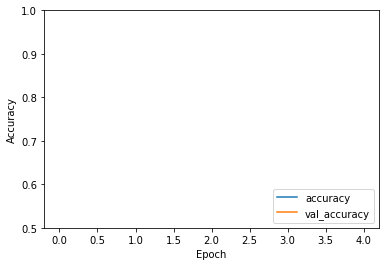

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_convolution.evaluate(train_data_array[train_unms:],  train_label_array[train_unms:], verbose=2)

In [18]:
model_convolution.evaluate(train_data_array[train_unms:],  train_label_array[train_unms:], verbose=2)

1080/1 - 1s - loss: 1.0529 - accuracy: 0.2046


[1.0540768649843004, 0.20462963]

In [19]:
#prediction 

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def recall_accuracy_rate(test_data_array,test_label_array,model):
    model_predict =[]
    for img in test_data_array:
        reshape = img.reshape(1,256,256,1)
        image = tf.cast(reshape, tf.float32)
        model_predict.append(np.argmax(model.predict(image)))
        
    matrix = confusion_matrix(test_label_array, model_predict)
    matrix_split = np.split(matrix,3,axis=1)
    print('column:* is prediction result')
    print('row*: is real class')
    dict = {
            "class:0":matrix_split[0].reshape(3),
            "class:1":matrix_split[1].reshape(3),
            "class:2":matrix_split[2].reshape(3)
           }
    
    predict_table = pd.DataFrame(dict)
    return predict_table,matrix

In [21]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [1]:
#testing data
predict_table1,matrix1 = recall_accuracy_rate(test_data_array,test_label_array,modelpredict)
for i in range(len(predict_table1.columns)):
    p = precision(i,matrix1)
    r = recall(i,matrix1) 
    print('The {} precision is {:.4f}% in {} prediction and recall is {:.4f}% in {} sample'
          .format(predict_table1.columns[i],p*100,matrix1[:,i].sum(),r*100,matrix1[i, :].sum()))
    print()

In [ ]:
predict_table1.head()

In [23]:

%load_ext tensorboard
file_writer = tf.summary.create_file_writer('/root/notebooks/0858611-2/tf-explain/logs')
%tensorboard --logdir '/root/notebooks/0858611-2/tf-explain/logs'


Reusing TensorBoard on port 6007 (pid 10912), started 3:19:55 ago. (Use '!kill 10912' to kill it.)

In [25]:
test_images = test_data_array
test_labels = test_label_array

In [28]:
# Select a subset of the validation data to examine
# Here, we choose 5 elements with one hot encoded label "0" == [1, 0, 0, .., 0]
validation_class_zero = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(np.argmax(label) == 0)
][0:5]), None)

In [29]:
# Select a subset of the validation data to examine
# Here, we choose 5 elements with one hot encoded label "4" == [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
validation_class_fours = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(np.argmax(label) == 2)
][0:5]), None)

In [30]:
# Instantiate callbacks
# class_index value should match the validation_data selected above
callbacks = [
    tf_explain.callbacks.GradCAMCallback(validation_class_zero, layer_name='target_layer', class_index=0),
    tf_explain.callbacks.GradCAMCallback(validation_class_fours, layer_name='target_layer', class_index=2),
    tf_explain.callbacks.ActivationsVisualizationCallback(validation_class_zero, layers_name=['target_layer']),
    tf_explain.callbacks.SmoothGradCallback(validation_class_zero, class_index=0, num_samples=15, noise=1.),
    tf_explain.callbacks.IntegratedGradientsCallback(validation_class_zero, class_index=0, n_steps=10),
    tf_explain.callbacks.VanillaGradientsCallback(validation_class_zero, class_index=0),
]

In [31]:
modelpredict.fit(test_images,test_labels, epochs=5,batch_size = batch_size,callbacks=callbacks)

Train on 5620 samples
Epoch 1/5
5504/5620 [============================>.] - ETA: 0s - loss: 1.0117 - accuracy: 0.1374WARNING:tensorflow:From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
5620/5620 [==============================] - 12s 2ms/sample - loss: 1.0264 - accuracy: 0.1372
Epoch 2/5
5620/5620 [==============================] - 7s 1ms/sample - loss: 3.0005 - accuracy: 0.3084
Epoch 3/5
5620/5620 [==============================] - 7s 1ms/sample - loss: 0.9038 - accuracy: 0.6477
Epoch 4/5
5620/5620 [==============================] - 7s 1ms/sample - loss: 0.8672 - accuracy: 0.6473
Epoch 5/5
5620/5620 [==============================] - 6s 1ms/sample - loss: 0.8827 - accuracy: 0.6507


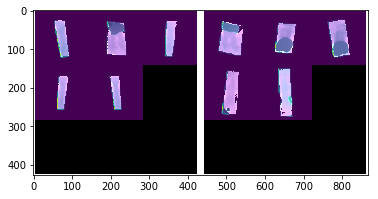

In [4]:
#heatmpa result 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/root/notebooks/0858611-2/tooth_xray/model/heatmap_result/tooth_model_convolution_rotate.PNG')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)